In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import copy
import qinfer as qi
from matplotlib.gridspec import GridSpec
from scipy import linalg

import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.markers as mmark
from matplotlib.ticker import PercentFormatter

from lfig import LatexFigure
sys.path.append("/home/bf16951/QMD")
import qmla

# Load results

In [2]:
save_path = os.path.abspath("../experimental_study/figures/")
run_path = os.path.abspath("../qmla_run_data/Sep_09/12_00")
instance_id = '004' # bc instance 69 has ~ 50 branches and true model won 
storage_instance = pickle.load(
    open(
        os.path.join(run_path, "storage_{}.p".format(instance_id)),
        'rb'
    )
)
all_models_generated = pd.read_csv(
    os.path.join(
        run_path, 
        "combined_datasets", 
        "models_generated.csv"
))
combined_results = pd.read_csv(
    os.path.join(run_path, 'combined_results.csv')
)

true_measurements = pickle.load(
    open(
        os.path.join(
            run_path, 
            'system_measurements.p'
        ), 'rb'
    )
)


# win/model rate

true_chromosome = storage_instance.growth_rule_storage.true_model_chromosome
true_chromosome = np.array([int(i) for i in list(true_chromosome)])

n_terms = len(true_chromosome)

# Evaluation datapoints

In [3]:
eval_data = pickle.load(open(os.path.join(run_path, "evaluation_data.p"), 'rb'))

eval_probes = eval_data['probes']
eval_experiments = eval_data['experiments']

In [4]:
qmla.utilities.plot_probes_on_bloch_sphere(
    eval_probes, 
    save_to_file=os.path.join(save_path, "nv_ga_eval_probes.pdf")
)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


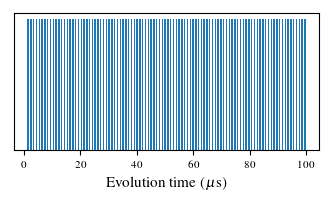

In [5]:
eval_times = [e['t'] for e in eval_experiments]

amplified_eval_times = [t*1e6 for t in eval_times]


lf = LatexFigure(fraction=0.5, auto_label=False)
ax = lf.new_axis()

ax.hist(
    amplified_eval_times,
    bins = len(amplified_eval_times),
    rwidth=0.5,
    align='mid'
)
ax.set_xlabel(r"Evolution time ($\mu \textrm{s}$)")
ax.set_yticks([])
# lf.save(os.path.join(save_path, "nv_ga_eval_times.pdf"))

# Raw data

In [6]:

fig_base_size = 5
marker_size = fig_base_size
linewidth = fig_base_size / 5
title_padding = fig_base_size / 4

storage_instance.expectation_values['time_microseconds'] = storage_instance.expectation_values['time']*1e6

times = sorted(true_measurements.keys())
times_microseconds = [t*1e6 for t in times]

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


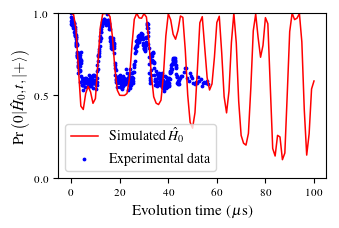

In [115]:
lf = LatexFigure(
    auto_gridspec=1, 
    auto_label=False,
    gridspec_params = {'wspace' : 0.05},
    fraction=0.5
)

# simulated data
ax = lf.new_axis()
ax.plot(
    times_microseconds,
    [true_measurements[t] for t in times],
    color='red', 
    lw = linewidth*1.1, 
    label=r"Simulated  $\hat{H}_0$"
)
ax.set_ylim(0,1)

# experimental data
data_path = "/home/bf16951/QMD/qmla/exploration_strategies/nv_centre_spin_characterisation/data"
revival_data = pickle.load(open(os.path.join(data_path, "NV_revivals.p"), 'rb'))
revival_times = sorted(revival_data.keys())
revival_ev = [revival_data[t] for t in revival_times]

ax.scatter(
    revival_times, 
    revival_ev, 
    s=3, 
    c='b',
    label=r"Experimental data"
)

ax.set_ylabel(r"$\Pr\left(0 | \hat{H}_0, t, |+\rangle \right)$")
ax.set_xlabel(r"Evolution time ($\mu \textrm{s}$)")
ax.set_ylim(0,1)
ax.set_yticks([0, 0.5, 1.0])

ax.legend()
# lf.save(
#     os.path.join(save_path, "nv_revival_raw_data.pdf")
# )

# Dynamics of branch champions

In [7]:
# Plot branch champions' dynamics
colours = itertools.cycle(['blue', 'indigo', 'green'])
linestyles = itertools.cycle(['dotted', 'dashed' , 'dashdot'])

storage_instance.expectation_values['microseconds'] = 1e6 * storage_instance.expectation_values.time

storage_instance.expectation_values['time_microseconds'] = storage_instance.expectation_values['time']*1e6
times = sorted(true_measurements.keys())
times_microseconds = [t*1e6 for t in times]


In [8]:
def branch_champ_dynamics(storage_instance, ax, colour_by_f=False):
    # branches = [5, 20, 50]
    f_score_cmap = mpl.cm.RdBu
    
    branches = [10, 20, 50,]
    # True dynamics
    ax.scatter(
        times_microseconds,
        [true_measurements[t] for t in times],
        color='red', 
        s = 2*marker_size, 
        label = r"$\hat{H}_0$"
    )
    ax.plot(
        times_microseconds,
        [true_measurements[t] for t in times],
        color='red', 
        lw = linewidth*0.2, 
    )

    # Plot branch champions' dynamics
    branch_champs_f_scores = {
        b : storage_instance.model_f_scores[storage_instance.branch_champions[b]]
        for b in storage_instance.branch_champions.keys()
    }
    
    if colour_by_f:
        colours = [
            f_score_cmap(branch_champs_f_scores[b]) for b in branches
        ]
        lines = ['--', '-', ':' , '--']
    else:
        colours = [
#             'indigo',
            'darkorange',
            'green',
            f_score_cmap(0.95)
#             'blue', 
        ]
#         colours = [
#             f_score_cmap(f) for f in [0.6, 0.8, 0.95]
#         ]
        lines = ['dotted', 'dashed' , 'dashdot']
        
    colours = itertools.cycle(colours)
    linestyles = itertools.cycle(lines)

    storage_instance.expectation_values['microseconds'] = 1e6 * storage_instance.expectation_values.time
    if branches is None:
        branches = sorted(storage_instance.branch_champions.keys())
    for b in branches:
        m = storage_instance.branch_champions[b]
        df = storage_instance.expectation_values[
            storage_instance.expectation_values.model_id == m
        ]

        ax.plot(
            times_microseconds, 
            df.exp_val, 
            c = next(colours),
            ls = next(linestyles), 
            label = "{}".format(b)
        )


    ax.legend(
#         title='Generation champions',
        ncol = 2, 
#         loc='lower left'.
        fontsize='x-small', 
    )
    ax.set_ylim(-0.25,1.1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_ylabel(
        r"$\Pr\left( 0 | \hat{H}_{C(\mu)}, t, |+\rangle \right)$",
    )
    ax.set_xlabel(
        r'$t \ (\mu \textrm{s}$)',
    )

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


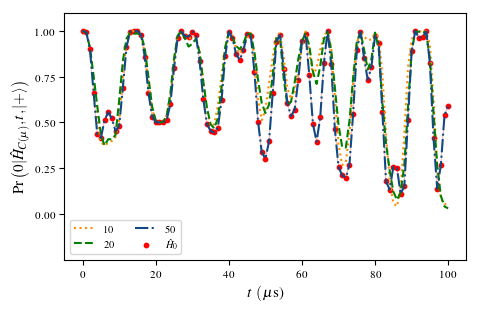

In [9]:
lf = LatexFigure(auto_label=False, fraction=0.75)
ax = lf.new_axis()
branch_champ_dynamics(storage_instance, ax, colour_by_f=False)
# lf.save(
#     os.path.join(save_path, "nv_ga_branch_champion_dynamics.pdf")
# )

# Gene pool

In [10]:
def gene_pool_progression(gene_pool, ax, draw_cbar=True, cbar_ax=None, cbar_orientation="vertical"):
    f_score_cmap = mpl.cm.RdBu
    num_models_per_generation = len(gene_pool[gene_pool.generation == 1])
    num_generations = gene_pool.generation.nunique()
    f_scores_of_gene_pool = np.empty((num_models_per_generation, num_generations))
    for g in gene_pool.generation.unique():

        f_scores_by_gen = gene_pool[
            gene_pool.generation == g
        ].f_score

        f_scores_of_gene_pool[:, g-1] = f_scores_by_gen

    sns.heatmap(
        f_scores_of_gene_pool,
        cmap = f_score_cmap,
        vmin = 0, 
        vmax=1,
        ax = ax,
        cbar_ax=cbar_ax,
        cbar=draw_cbar, 
        cbar_kws = dict(
            label=r"$F_1$-score",
            aspect=25, 
            ticks=[0,0.5,1],
            orientation=cbar_orientation
        )
    )
    ax.set_yticks([])
    xtick_pos = range(10, num_generations+1, 10)
    ax.set_xticks([g-0.5 for g in xtick_pos])
    ax.set_xticklabels(
        xtick_pos
    )
    ax.set_xlabel('Generation')

    if cbar_ax is not None:
        cbar = ax.collections[0].colorbar
        cbar.ax.set_ylabel(r"$F_1$", rotation=0, labelpad=10) # if F horizontal
        cbar.ax.yaxis.set_label_position("right", )
        cbar.ax.tick_params(labelleft=True, labelright=False )

In [11]:
gene_pool = storage_instance.growth_rule_storage.gene_pool
gene_pool.sort_values('f_score', inplace=True, ascending=False)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


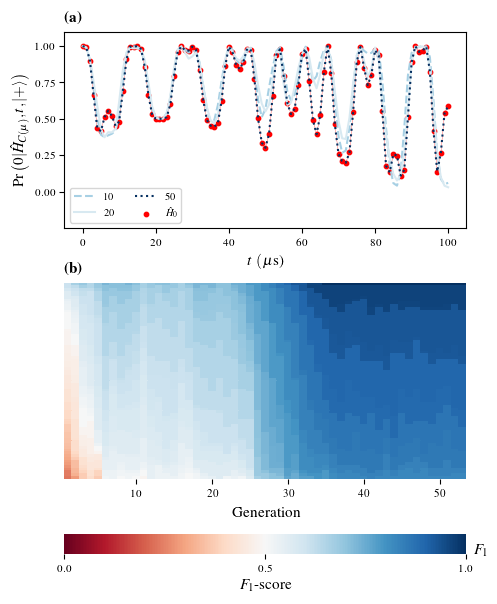

In [12]:
lf = LatexFigure(
    fraction=0.75, 
    gridspec_layout=(3,1),
    gridspec_params = {
        'hspace' : 0.4, 
        'height_ratios' : [1,1,0.1]
    },
    auto_label=False,
    legend_axis=(2,0)
)

ax = lf.new_axis(label="a")
branch_champ_dynamics(storage_instance, ax, colour_by_f=True)


ax = lf.new_axis(label="b")
gene_pool_progression(gene_pool, ax,cbar_ax=lf.legend_ax, cbar_orientation="horizontal")

# lf.save(os.path.join(save_path, "nv_ga_instance.pdf"))

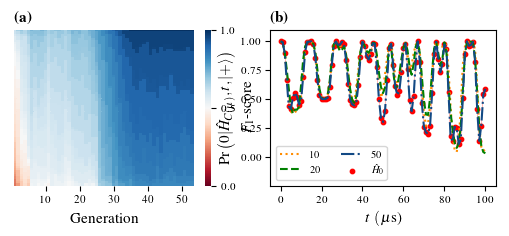

In [13]:
lf = LatexFigure(
#     fraction=0.75, 
    gridspec_layout=(1,3),
    gridspec_params = {
#         'space' : 0.4, 
        'width_ratios' : [1,1,0.1]
    },
    auto_label=False,
#     legend_axis=(0,2)
)

ax = lf.new_axis(label="a")
gene_pool_progression(gene_pool, ax, draw_cbar=True, cbar_ax=None, cbar_orientation="vertical")

ax = lf.new_axis(label="b")
branch_champ_dynamics(storage_instance, ax, colour_by_f=False)

# lf.save(os.path.join(save_path, "nv_ga_instance_horiz.pdf"))

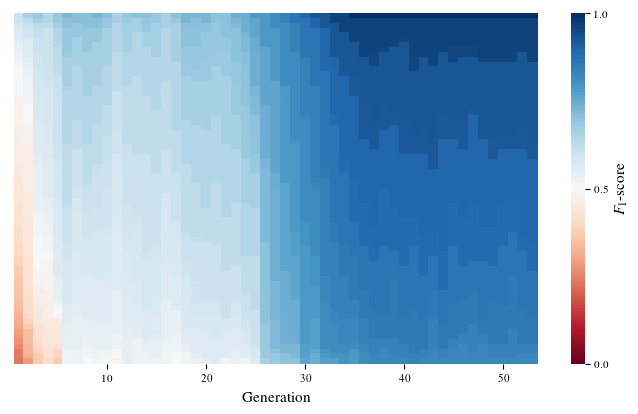

In [16]:
lf = LatexFigure(
#     fraction=0.75, 
    auto_label=False,
)

ax = lf.new_axis()
gene_pool_progression(gene_pool, ax, draw_cbar=True, cbar_ax=None, cbar_orientation="vertical")


lf.save(os.path.join(save_path, "nv_ga_instance_gene_pool.pdf"))